<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Bayesianos</div><br>
    <div style="font-size: x-large; color:gray">Practica: Mixtura de Gausianas</div><br>
    <div style="font-size: large; color:#FF0000">Francisco Javier Sáez Maldonado -  José Antonio Álvarez Ocete</div><br></div><hr>
</div>

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Ejercicio"; display: block; margin: 0px 10px 10px 10px;}
           
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

Se debe implementar un modelo de mixtura de gausianas mediante el algoritmo de esperanza-maximización (EM). Este modelo se utiliza para estimar una densidad de probabilidad a partir de $N$ puntos en $D$ dimensiones, $\mathcal{D}=\{\mathbf{x}_i\}_{i=1}^N$, basado en $K$ gausianas

$$    p(\mathbf{X}) = \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{X}; \mathbf{\mu_k}, \Sigma_k) $$

donde $\pi_k$ es la probabilidad de observar un punto en la gausiana $k$ con $\sum_{k=1}^K \pi_k = 1$ y donde $\mathbf{\mu_k}, \Sigma_k$ son la media y la matriz de covarianza respectivamente de la gausiana $k$.

Para resolver este problema vamos a plantearlo con la siguiente red de bayes:

donde la variable $\mathbf{Z}$ indica la gausiana a la que pertenece cada dato codificado como 1-en-K, esto es, $\mathbf{Z}$ es un vector binario de K componentes donde una y solo una vale 1 y el resto 0. Si $z_{ik}=1$ entonces el ejemplo $\mathbf{X}_i$ pertence a la gausiana $k$. Donde 

$$ p(\mathbf{X}) = \sum_{k=1}^K p(z_k=1) p(\mathbf{X}|z_k=1) $$

donde $p(z_k=1)=\pi_k$ y $p(\mathbf{X}|z_k=1) =  \mathcal{N} (\mathbf{X}; \mathbf{\mu_k}, \Sigma_k) $.

Para aplicar el algoritmo EM tenemos que la variable no observada es la $\mathbf{Z}$ para todos los ejemplos, por lo que en el paso E debemos estimar la probabilidad de observar 1 para cada uno de las $K$ entradas en $Z$ para cada uno de los ejemplos en $\mathcal{D}$. 

<u>Paso E:</u>

En el **paso E**, estimaremos $D \times K$ valores de la siguiente forma:

$$ q_i(z_k=1) = \frac{p(z_k=1)p(\mathbf{X}|z_k=1)}{\sum_{k=1}^K p(z_k=1)p(\mathbf{X}|z_k=1)} $$

**Editado por Dreji**: estimaremos $N \times K$ valores de la siguiente forma:

$$
q_i(z_k=1) = \frac{p(z_k=1)p(x_i|z_k=1)}{\sum_{k=1}^K p(z_k=1)p(x_i|z_k=1)}
= \frac{\pi_k \cdot \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)}{\sum_{k=1}^K \pi_k \cdot \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)}
$$

<u>Paso M:</u>

En el **paso M** lo que debemos hacer es estimar los parámetros del modelo a partir de los datos como se indica a continuación.

$$ \pi_k = \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) $$

$$ \mathbf{\mu}_k = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i $$

$$ \Sigma_k = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T $$

Finalmente la log-verosimilitud de los datos la podemos escribir como

$$ \ln p(\mathbf{X}|\pi, \mathbf{\mu}, \Sigma) = \sum_{i=1}^N \ln \left[ \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)  \right]$$ 

**Editado por Dreji**:

En el **paso M** lo que debemos hacer es estimar los parámetros del modelo a partir de los datos como se indica a continuación.

$$ \pi_k = \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) $$

$$
\begin{align*}
\mathbf{\mu}_k & = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i \\
& = \frac{1}{\frac{1}{N}\sum_{i=1}^N q_i(z_k=1)} \frac{1}{N}\sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i \\
& = \frac{1}{\pi_k} \frac{1}{N}\sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i \\
\end{align*}
$$

Como $q_i(z_k=1)$ es la columna $k-$ésima de la matriz $Q$ calculada en el paso E, basta con multiplicar la matriz $X$ (fila a fila) por la columna $k$ de la matriz $Q$ elemento a elemento y calcular la media. Finalmente, dividimos por el valor $\pi_k$ para obtener $\mu_k$.

$$
\begin{align*}
\Sigma_k & = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T \\
& = \frac{1}{\frac{1}{N}\sum_{i=1}^N q_i(z_k=1)} \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T \\
& = \frac{1}{\pi_k} \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T \\
\end{align*}
$$

Finalmente la log-verosimilitud de los datos la podemos escribir como

$$ \ln p(\mathbf{X}|\pi, \mathbf{\mu}, \Sigma) = \sum_{i=1}^N \ln \left[ \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)  \right]$$ 

## Problemas numéricos
En la implementación de este método surgen diversos problemas numéricos:
- La matriz de covarianza debe ser semi-definida positiva. Para garantizar que las estimaciones que tenemos de la matriz de covarianza lo cumplen, se puede añadir un valor pequeño de regularización a la diagonal de la matriz (~1e10-5).
- El cálculo de los valores de $q$ supone el cálculo de una gausiana y puede darse el caso de que para algún ejemplo y para todo $k$ el valor sea 0. Para evitar esto se puede sumar una cantidad muy pequeña siempre a todos los valores de $q$ antes de normalizar. Adicionalmente se recomienda calcular esta probailidad como log prob y luego utilizar la función `np.logsumexp` para normalizar en el espacio de logprobs. 
- Finalmente, para evitar problemas numéricos al invertir la matriz de covarianza, se recomienda usar la descomposición de Choleski esto es: <tt>covinv = scipy.linalg.cho_solve(scipy.linalg.cho_factor(covariaza), I)</tt>, donde <tt>I</tt> es la matriz identidad.

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib
import scipy 
import matplotlib as mpl

from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal


%matplotlib inline
%load_ext autoreload
%autoreload 2

matplotlib.rcParams['figure.figsize'] = (10,6)

In [3]:
import matplotlib.transforms as transforms

def make_ellipse(cov, mean, ax, n_std=3.0, **kwargs):
    """
        Adaptado de: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
        
        En kwargs se pueden poner todo tipo de argumentos para dibujar la elipse. Por ejemplo
        para que la elipse sea naranja semitransparente con borde rojo sería:
            
            def make_ellipse(cov, mean, ax, n_std=3.0, facecolor='orange', edgecolor='red', alpha=0.5)
            
    """
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = mpl.patches.Ellipse(
        (0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs
    )

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # Calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    color = kwargs['edgecolor'] if 'edgecolor' in kwargs else 'red'
    ax.scatter(mean_x, mean_y, marker='x', c=color)

    return ax.add_patch(ellipse)

In [141]:
# Generar datos
def generate_dataset(N = 100, rotate=True, K=3, random_state=12345):
    X, y = make_blobs(N, centers=K, random_state=random_state)
    transformation = np.identity(2)
    if rotate:
        np.random.seed(random_state)
        transformation = np.array([[ (0.2+np.random.rand())*2,  0.5-np.random.rand()], 
                                       [0.5-np.random.rand(), (0.2+np.random.rand())*2]])
        for y_k in np.unique(y):
            X[y==y_k, :] = np.dot(X[y==y_k, :], transformation)

    return X, y, transformation

def plot_elipses(X, y, transformation):
    fig = plt.figure()
    for y_k in np.unique(y):
        plt.scatter(X[y==y_k, 0], X[y==y_k, 1], label=y_k)
        make_ellipse(transformation, np.mean(X[y==y_k, :], axis=0),
                     ax=fig.axes[0], facecolor='none',
                     edgecolor='red')

    fig.axes[0].axis('equal')
    plt.legend()
    return fig

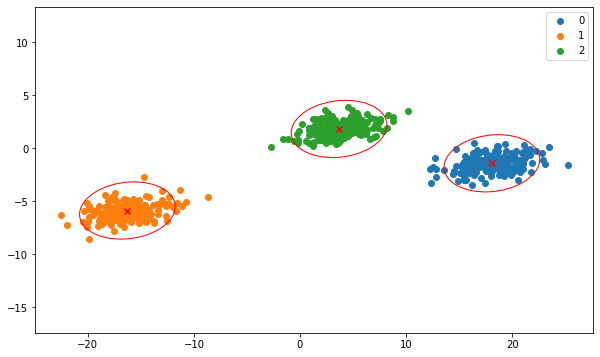

In [142]:
X, y, transformation = generate_dataset(N = 500)
_ = plot_elipses(X, y , transformation)

<div class="qst">

* Completa la clase `GMM` satisfaciendo los requisitos indicados anteriormente.

</div>

In [143]:
class GMM:
    """ 
        Sugerencia para la organización del código
    """
    
    def __init__(self, K=3, n_iterations=100, random_state=1234, reg_value=1e-10):
        self.K = K
        self.n_iterations = n_iterations
        self._random_state = random_state
        self.log_likelihoods = []
        
        # Value added to the diagonal of the covariance matrices
        # to avoid singular matrix due to numerical errors.
        self._regularization_val = reg_value
        self._regularization_matrix = reg_value * np.identity(X.shape[1])
    
    def _initialize(self, X):
        # Apply k-means for a initial prediction of the clusters
        y_pred = KMeans(n_clusters=self.K, random_state=self._random_state).fit_predict(X)
        
        # Predict initial quantities using the obtained labels
        labels = np.unique(y_pred)
        pi_prior = np.array([ np.sum(y_pred == i) for i in labels ]) / len(y_pred)
        means = np.array([ np.mean(X[y_pred == i], axis=0) for i in labels ])
        
        # Add a small quantity to the covariance matrices' diagonals
        # so they are not singular
        covs = np.array([
            np.cov(X[y_pred == i].T) + self._regularization_matrix
            for i in labels
        ])
        
        pi_prior = np.array([0.5, 0.1, 0.4])
        means = np.arange(6).reshape(3,2)
        covs = np.array([np.identity(2)] * 3)
        
        return pi_prior, means, covs

    def _e_step(self, X, priors, means, covs):

        # Initialize multivariate normal distributions
        distributions = [
            multivariate_normal(mean=mean, cov=cov)
            for mean, cov in zip(means, covs)
        ]
        
        # Compute the numerator of the Q matrix
        # Add a small regularization value to avoid numerical errors
        Q = np.array([ mvn.pdf(X) for mvn in distributions ]).T * priors + self._regularization_val
        
        # Normalize Q matrix, by dividing each row by the sum of its values.
        Q = Q / np.sum(Q, axis=1).reshape(-1, 1)
        return Q
    
    def _m_step(self, X, Q):
        # Estimate pi
        priors = np.mean(Q, axis=0)
        
        # Estimate means
        means = [
            np.mean(X * Q[:, k].reshape(-1, 1), axis=0) / pi_k
            for k, pi_k  in enumerate(priors)
        ]
        
        
        
        
        # Estimate covariances
        covs = [
            np.mean([
                Q[i, k] * np.matmul((x_i - mean_k).reshape(-1,1), (x_i - mean_k).reshape(1,-1))
                for i, x_i in enumerate(X)
            ], axis = 0) / pi_k
            + self._regularization_matrix
            for k, (pi_k, mean_k)  in enumerate(zip(priors, means))
        ]
        
        print("M- step")
        print("priors :",priors)
        print("means :",means)
        print("covs :",covs)
            
            
        return priors, means, covs
        
    def _compute_log_likelihood(self, X, priors, means, covs):
        # Initialize multivariate normal distributions
        distributions = [
            multivariate_normal(mean=mean, cov=cov)
            for mean, cov in zip(means, covs)
        ]
        
        return np.sum([
            np.log(np.sum([
                pi_k * mvn.pdf(x_i)
                for pi_k, mvn in zip(priors, distributions)
            ]))
            for x_i in X
        ])
        
    def fit(self, X):
        # Parameter initialization
        priors, means, covs = self._initialize(X)
        
        # Initialize the log-likelihoog vector
        self.log_likelihoods = [
            self._compute_log_likelihood(X, priors, means, covs)
        ]
        
        for i in range(self.n_iterations):
            eeeeeeyy
            
            # Step E
            Q = self._e_step(X, priors, means, covs)
            print('Q: ', Q[:3])
            
            # Step M
            priors, means, covs = self._m_step(X, Q)
            
            # Compute and save log-likelihood
            self.log_likelihoods.append(
                self._compute_log_likelihood(X, priors, means, covs)
            )
        
        return priors, means, covs

In [144]:
gmm = GMM(n_iterations = 100,reg_value=1e-10)
priors, means, covs = gmm.fit(X)

--------- Iteration 0
priors:  [0.5 0.1 0.4]
means:  [[0 1]
 [2 3]
 [4 5]]
covs:  [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
Q:  [[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.35804123 0.63441669 0.00754208]]
M- step
priors : [0.31100899 0.34494255 0.34404845]
means : [array([ 1.06220891, -2.27393668]), array([ 1.74361303, -1.70804571]), array([ 2.62516842, -1.58232414])]
covs : [array([[215.9124032 ,  28.42201819],
       [ 28.42201819,   8.94318091]]), array([[195.73133081,  27.98990971],
       [ 27.98990971,  10.69047722]]), array([[200.69597022,  31.67271314],
       [ 31.67271314,  11.66945485]])]
--------- Iteration 1
priors:  [0.31100899 0.34494255 0.34404845]
means:  [array([ 1.06220891, -2.27393668]), array([ 1.74361303, -1.70804571]), array([ 2.62516842, -1.58232414])]
covs:  [array([[215.9124032 ,  28.42201819],
       [ 28.42201819,   8.94318091]]), array([[195.73133081,  27.98990971],
       [ 27.98990971,  10.69047722]]

--------- Iteration 9
priors:  [0.65094699 0.16666875 0.18238426]
means:  [array([ 0.73000334, -3.71668331]), array([3.8078636 , 1.62297207]), array([3.97590592, 1.68916179])]
covs:  [array([[301.63429731,  38.8369274 ],
       [ 38.8369274 ,   5.52559136]]), array([[17.85930477,  1.7547206 ],
       [ 1.7547206 ,  1.36725538]]), array([[13.79135756,  0.66739777],
       [ 0.66739777,  1.00680453]])]
Q:  [[9.99987755e-01 6.80568681e-06 5.43911051e-06]
 [9.99997374e-01 1.61484707e-06 1.01067005e-06]
 [7.85325725e-09 4.26931527e-01 5.73068465e-01]]
M- step
priors : [0.66741455 0.14802696 0.18455849]
means : [array([ 0.90213691, -3.65853554]), array([3.68402519, 1.79573785]), array([3.72539702, 1.81597537])]
covs : [array([[300.67512457,  38.86996479],
       [ 38.86996479,   5.60683973]]), array([[5.58270745, 0.79062564],
       [0.79062564, 0.64496997]]), array([[4.72236969, 0.53777663],
       [0.53777663, 0.55802945]])]
--------- Iteration 10
priors:  [0.66741455 0.14802696 0.18455849

--------- Iteration 18
priors:  [0.66799998 0.14752476 0.18447526]
means:  [array([ 0.91357629, -3.65524671]), array([3.82448295, 1.71855253]), array([3.58049701, 1.88310938])]
covs:  [array([[300.61222053,  38.88400954],
       [ 38.88400954,   5.614851  ]]), array([[6.49841971, 1.18071549],
       [1.18071549, 0.59304319]]), array([[3.46165446, 0.28333406],
       [0.28333406, 0.57823621]])]
Q:  [[9.99999953e-01 2.34666638e-08 2.34666638e-08]
 [9.99999933e-01 3.35129218e-08 3.35129218e-08]
 [3.41937239e-09 4.26018699e-01 5.73981298e-01]]
M- step
priors : [0.66799998 0.14776636 0.18423366]
means : [array([ 0.91357632, -3.6552467 ]), array([3.85979391, 1.69990612]), array([3.55185548, 1.89828072])]
covs : [array([[300.61221985,  38.88400957],
       [ 38.88400957,   5.61485105]]), array([[6.66185674, 1.23451066],
       [1.23451066, 0.58454214]]), array([[3.31086748, 0.24833514],
       [0.24833514, 0.57956853]])]
--------- Iteration 19
priors:  [0.66799998 0.14776636 0.18423366]
means

--------- Iteration 27
priors:  [0.668      0.15382298 0.17817702]
means:  [array([ 0.91357656, -3.65524654]), array([4.07266191, 1.61407863]), array([3.35761518, 1.97912022])]
covs:  [array([[300.61221073,  38.88400931],
       [ 38.88400931,   5.61485159]]), array([[6.95804107, 1.35752978],
       [1.35752978, 0.5523294 ]]), array([[2.74800659, 0.20143362],
       [0.20143362, 0.56357941]])]
Q:  [[9.99999953e-01 2.34666657e-08 2.34666657e-08]
 [9.99999933e-01 3.35129178e-08 3.35129178e-08]
 [3.33151672e-09 4.03768921e-01 5.96231075e-01]]
M- step
priors : [0.668      0.15496067 0.17703932]
means : [array([ 0.91357658, -3.65524653]), array([4.09015348, 1.60976452]), array([3.3377099 , 1.98524216])]
covs : [array([[300.61221013,  38.88400929],
       [ 38.88400929,   5.61485163]]), array([[6.93362407, 1.35244139],
       [1.35244139, 0.55042109]]), array([[2.71647908, 0.20861237],
       [0.20861237, 0.56165507]])]
--------- Iteration 28
priors:  [0.668      0.15496067 0.17703932]
means

--------- Iteration 36
priors:  [0.66800001 0.16652535 0.16547464]
means:  [array([ 0.91357662, -3.65524649]), array([4.19079313, 1.59495262]), array([3.18384441, 2.0263895 ])]
covs:  [array([[300.6122082 ,  38.8840092 ],
       [ 38.8840092 ,   5.61485174]]), array([[6.64567753, 1.29043495],
       [1.29043495, 0.53807967]]), array([[2.48567715, 0.26789297],
       [0.26789297, 0.55189932]])]
Q:  [[9.99999953e-01 2.34666664e-08 2.34666664e-08]
 [9.99999933e-01 3.35129170e-08 3.35129170e-08]
 [3.27927822e-09 4.05616440e-01 5.94383556e-01]]
M- step
priors : [0.66800001 0.16818314 0.16381686]
means : [array([ 0.91357662, -3.65524649]), array([4.19887847, 1.59446827]), array([3.16535351, 2.03125278])]
covs : [array([[300.61220816,  38.88400919],
       [ 38.88400919,   5.61485174]]), array([[6.60467072, 1.28239319],
       [1.28239319, 0.53683555]]), array([[2.45829191, 0.27437352],
       [0.27437352, 0.55097983]])]
--------- Iteration 37
priors:  [0.66800001 0.16818314 0.16381686]
means

--------- Iteration 45
priors:  [0.66800001 0.18170869 0.1502913 ]
means:  [array([ 0.9135766, -3.6552465]), array([4.23114337, 1.59367387]), array([3.03333123, 2.07152194])]
covs:  [array([[300.6122083 ,  38.88400913],
       [ 38.88400913,   5.61485172]]), array([[6.28957402, 1.22514316],
       [1.22514316, 0.52907232]]), array([[2.27064709, 0.31687926],
       [0.31687926, 0.54200798]])]
Q:  [[9.99999953e-01 2.34666665e-08 2.34666665e-08]
 [9.99999933e-01 3.35129172e-08 3.35129172e-08]
 [3.23879526e-09 4.32448930e-01 5.67551066e-01]]
M- step
priors : [0.66800001 0.18335318 0.14864681]
means : [array([ 0.9135766, -3.6552465]), array([4.23180783, 1.59367779]), array([3.01926016, 2.07680357])]
covs : [array([[300.61220835,  38.88400913],
       [ 38.88400913,   5.61485171]]), array([[6.25421635, 1.21901267],
       [1.21901267, 0.52833896]]), array([[2.25176365, 0.32118525],
       [0.32118525, 0.54050627]])]
--------- Iteration 46
priors:  [0.66800001 0.18335318 0.14864681]
means:  [

--------- Iteration 54
priors:  [0.66800001 0.19561373 0.13638626]
means:  [array([ 0.91357657, -3.65524651]), array([4.22145547, 1.59302068]), array([2.92510535, 2.12117699])]
covs:  [array([[300.61220878,  38.88400909],
       [ 38.88400909,   5.61485168]]), array([[6.01347441, 1.17776219],
       [1.17776219, 0.52362518]]), array([[2.13206516, 0.35043791],
       [0.35043791, 0.52449797]])]
Q:  [[9.99999953e-01 2.34666665e-08 2.34666665e-08]
 [9.99999933e-01 3.35129176e-08 3.35129176e-08]
 [3.24366358e-09 4.71355104e-01 5.28644892e-01]]
M- step
priors : [0.66800001 0.19702666 0.13497333]
means : [array([ 0.91357657, -3.65524651]), array([4.21888513, 1.59284239]), array([2.91528692, 2.12696611])]
covs : [array([[300.61220883,  38.88400909],
       [ 38.88400909,   5.61485167]]), array([[5.98824664, 1.1734648 ],
       [1.1734648 , 0.52312726]]), array([[2.12028959, 0.35362962],
       [0.35362962, 0.52200535]])]
--------- Iteration 55
priors:  [0.66800001 0.19702666 0.13497333]
means

--------- Iteration 63
priors:  [0.66800001 0.20744932 0.12455068]
means:  [array([ 0.91357656, -3.65524652]), array([4.19392942, 1.59106827]), array([2.84776498, 2.17461762])]
covs:  [array([[300.61220922,  38.88400909],
       [ 38.88400909,   5.61485164]]), array([[5.81673116, 1.14416808],
       [1.14416808, 0.51937276]]), array([[2.04285111, 0.37688106],
       [0.37688106, 0.49885888]])]
Q:  [[9.99999953e-01 2.34666664e-08 2.34666664e-08]
 [9.99999933e-01 3.35129178e-08 3.35129178e-08]
 [3.28580901e-09 5.15202090e-01 4.84797907e-01]]
M- step
priors : [0.66800001 0.20865138 0.12334861]
means : [array([ 0.91357656, -3.65524652]), array([4.19048616, 1.59085655]), array([2.84047071, 2.18066259])]
covs : [array([[300.61220927,  38.88400909],
       [ 38.88400909,   5.61485164]]), array([[5.79856502, 1.14101866],
       [1.14101866, 0.51891356]]), array([[2.03475088, 0.3795126 ],
       [0.3795126 , 0.49566259]])]
--------- Iteration 64
priors:  [0.66800001 0.20865138 0.12334861]
means

--------- Iteration 72
priors:  [0.66800001 0.21753795 0.11446204]
means:  [array([ 0.91357655, -3.65524652]), array([4.16201495, 1.59006735]), array([2.78976891, 2.22795366])]
covs:  [array([[300.61220954,  38.8840091 ],
       [ 38.8840091 ,   5.61485163]]), array([[5.67555327, 1.11854989],
       [1.11854989, 0.51532667]]), array([[1.97681415, 0.39737762],
       [0.39737762, 0.46965958]])]
Q:  [[9.99999953e-01 2.34666663e-08 2.34666663e-08]
 [9.99999933e-01 3.35129179e-08 3.35129179e-08]
 [3.35367594e-09 5.62754070e-01 4.37245927e-01]]
M- step
priors : [0.66800001 0.21855765 0.11344234]
means : [array([ 0.91357655, -3.65524652]), array([4.15842014, 1.590134  ]), array([2.78435995, 2.23355903])]
covs : [array([[300.61220957,  38.88400911],
       [ 38.88400911,   5.61485163]]), array([[5.66283454, 1.11600658],
       [1.11600658, 0.51490611]]), array([[1.97009842, 0.39910002],
       [0.39910002, 0.46653422]])]
--------- Iteration 73
priors:  [0.66800001 0.21855765 0.11344234]
means

--------- Iteration 81
priors:  [0.66800001 0.22593966 0.10606034]
means:  [array([ 0.91357655, -3.65524652]), array([4.13050537, 1.59226181]), array([2.74818932, 2.27380981])]
covs:  [array([[300.61220976,  38.88400913],
       [ 38.88400913,   5.61485162]]), array([[5.58031172, 1.09717854],
       [1.09717854, 0.51206634]]), array([[1.9179164 , 0.40793827],
       [0.40793827, 0.44460542]])]
Q:  [[9.99999953e-01 2.34666663e-08 2.34666663e-08]
 [9.99999933e-01 3.35129180e-08 3.35129180e-08]
 [3.42322497e-09 6.10132589e-01 3.89867408e-01]]
M- step
priors : [0.66800001 0.22676168 0.10523832]
means : [array([ 0.91357655, -3.65524653]), array([4.12721128, 1.59270799]), array([2.74448992, 2.27817199])]
covs : [array([[300.61220978,  38.88400913],
       [ 38.88400913,   5.61485162]]), array([[5.57215437, 1.0950018 ],
       [1.0950018 , 0.51179279]]), array([[1.91154707, 0.40845657],
       [0.40845657, 0.44233065]])]
--------- Iteration 82
priors:  [0.66800001 0.22676168 0.10523832]
means

--------- Iteration 90
priors:  [0.66800001 0.23252214 0.09947786]
means:  [array([ 0.91357654, -3.65524653]), array([4.10342507, 1.59712587]), array([2.72001925, 2.30753866])]
covs:  [array([[300.61220999,  38.88400914],
       [ 38.88400914,   5.61485161]]), array([[5.51990801, 1.07908999],
       [1.07908999, 0.51027451]]), array([[1.86281431, 0.40935289],
       [0.40935289, 0.4278978 ]])]
Q:  [[9.99999953e-01 2.34666662e-08 2.34666662e-08]
 [9.99999933e-01 3.35129180e-08 3.35129180e-08]
 [3.47105863e-09 6.49901457e-01 3.50098540e-01]]
M- step
priors : [0.668      0.23314326 0.09885673]
means : [array([ 0.91357654, -3.65524653]), array([4.100814 , 1.5977348]), array([2.71748512, 2.31056613])]
covs : [array([[300.61221002,  38.88400915],
       [ 38.88400915,   5.61485161]]), array([[5.51469686, 1.07730121],
       [1.07730121, 0.51015817]]), array([[1.85711711, 0.40918848],
       [0.40918848, 0.42651404]])]
--------- Iteration 91
priors:  [0.668      0.23314326 0.09885673]
means: 

--------- Iteration 99
priors:  [0.668      0.23740052 0.09459948]
means:  [array([ 0.91357654, -3.65524653]), array([4.08290692, 1.60254018]), array([2.70016969, 2.33058638])]
covs:  [array([[300.61221024,  38.88400916],
       [ 38.88400916,   5.61485159]]), array([[5.48032731, 1.06466976],
       [1.06466976, 0.50962725]]), array([[1.81587394, 0.40704415],
       [0.40704415, 0.41794855]])]
Q:  [[9.99999953e-01 2.34666661e-08 2.34666661e-08]
 [9.99999933e-01 3.35129181e-08 3.35129181e-08]
 [3.49762526e-09 6.79223251e-01 3.20776746e-01]]
M- step
priors : [0.668      0.23785121 0.09414879]
means : [array([ 0.91357654, -3.65524653]), array([4.08102148, 1.60310863]), array([2.6983138 , 2.33263541])]
covs : [array([[300.61221027,  38.88400916],
       [ 38.88400916,   5.61485159]]), array([[5.47678112, 1.06329717],
       [1.06329717, 0.509598  ]]), array([[1.81129884, 0.40673566],
       [0.40673566, 0.41713232]])]


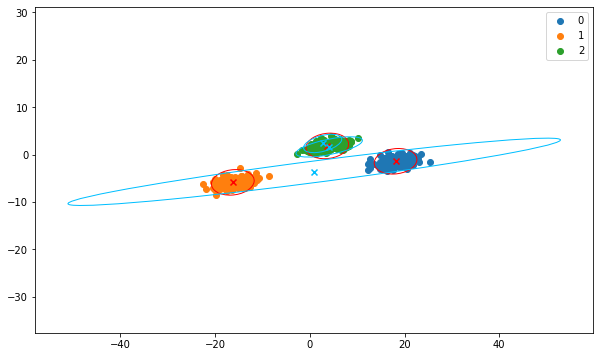

In [145]:
def plot_estimations(X, y, transformation, means, covs):
    fig = plot_elipses(X, y, transformation)
    
    for mean, cov in zip(means, covs):
        make_ellipse(cov, mean,ax=fig.axes[0], facecolor='none',
                     edgecolor='deepskyblue')

    fig.axes[0].axis('equal')
    _ = plt.legend()

plot_estimations(X, y, transformation, means, covs)

<div class="qst">

* Se deben **visualizar** los resultados obtenidos. Al menos se deben mostrar las covarianzas y medias finales estimadas (usando `make_ellipse`) y cómo ha evolucionado la log-verosimilitud de los datos.

</div>

[[2.25923219 0.18362445]
 [0.31608119 0.80912056]]
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


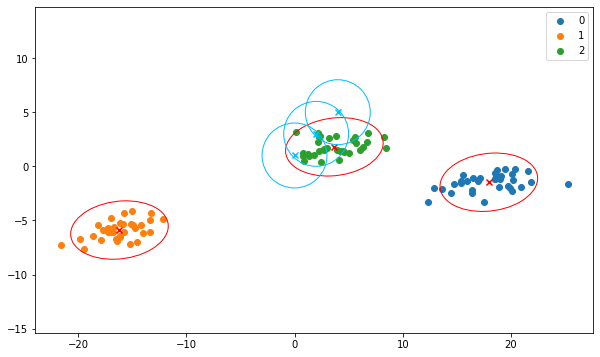

In [139]:
gmm = GMM(reg_value=1e-7)
priors, means, covs = gmm._initialize(X)
print(transformation)
print(covs)
plot_estimations(X, y, transformation, means, covs)

ValueError: x and y must have same first dimension, but have shapes (101,) and (0,)

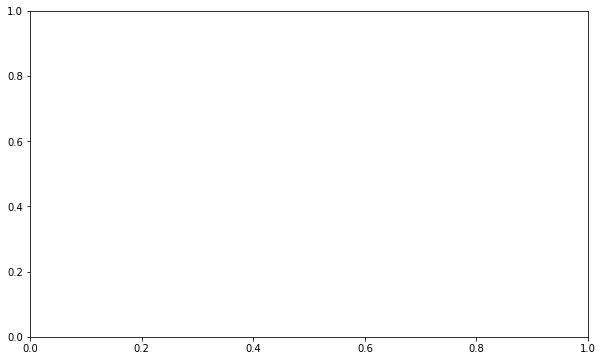

In [140]:
def plot_log_likelihood(gmm):
    plt.plot(np.arange(gmm.n_iterations + 1), gmm.log_likelihoods)


plot_log_likelihood(gmm)

In [107]:
print(np.arange(gmm.n_iterations + 1))
gmm.log_likelihoods

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]


[-11175.7934139549,
 -641.3060194964966,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.3060194964967,
 -641.30601949